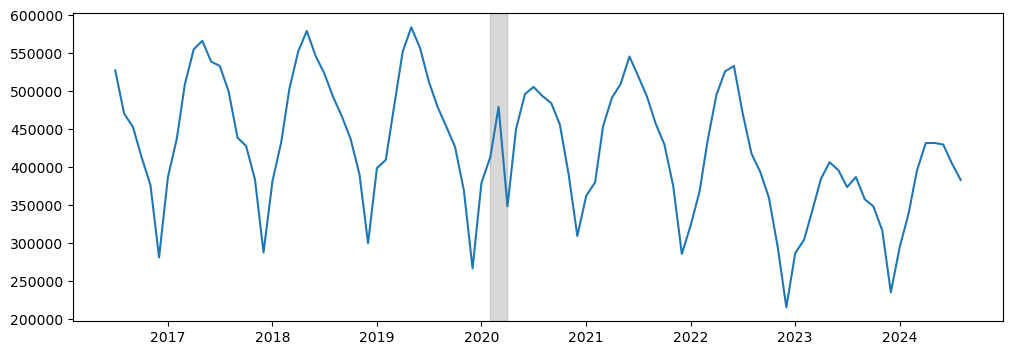

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = list(mcolors.TABLEAU_COLORS.keys())
plt.rcParams["figure.figsize"] = (12, 4)

recessions = pd.read_excel('data/List_of_recessions_in_the_United_States.xlsx')
recessions['Start'] = pd.to_datetime(recessions['Start'])
recessions['End'] = pd.to_datetime(recessions['End'])
# display(recessions.tail())

new_listings = pd.read_csv('data/NEWLISCOUUS.csv')
new_listings.rename(columns={"NEWLISCOUUS":'listings'}, inplace=True)
new_listings['DATE'] = new_listings['DATE'].astype('datetime64[us]')
plt.plot(new_listings.DATE, new_listings.listings)

# Adding shaded regions
for _, row in recessions.iterrows():
    if row['End'] > new_listings['DATE'].min():
        plt.axvspan(row['Start'], row['End'], color='gray', alpha=0.3)
    

In [4]:
new_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      98 non-null     datetime64[us]
 1   listings  98 non-null     float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 1.7 KB


In [5]:
from darts import TimeSeries, concatenate
from darts.utils.utils import ModelMode
from darts.utils.callbacks import TFMProgressBar
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf, stationarity_tests, extract_trend_and_seasonality
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler, Diff
from darts.models import *



c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\darts\timeseries.py:732: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


<Axes: xlabel='DATE'>

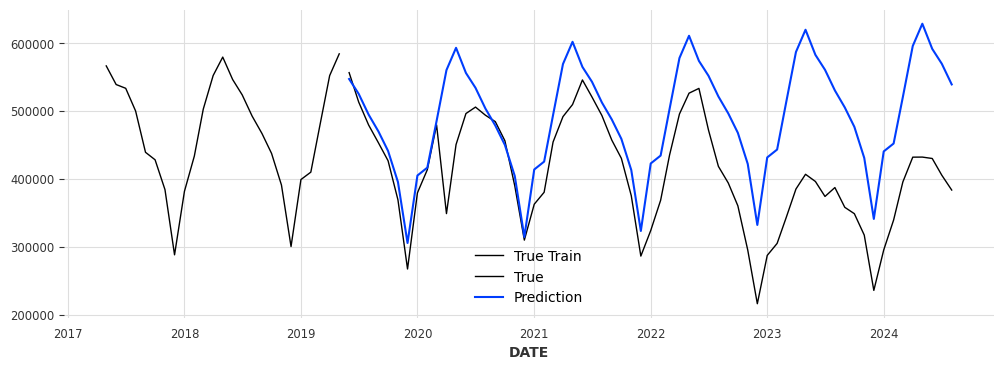

In [24]:
series = TimeSeries.from_dataframe(new_listings, time_col='DATE')
_, series = series.split_before(pd.Timestamp('2017-05-01'))
train, test = series.split_after(pd.Timestamp('2019-05-01'))

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

train.plot(label='True Train', linewidth=1, color='black')
test.plot(label='True', linewidth=1, alpha=1)
# seasonal_forecast.plot(label="naive forecast", linewidth=1, alpha=0.3)
# drift_forecast.plot(label="drift", linewidth=1, alpha=0.3)
combined_forecast.plot(label="Prediction", linewidth=1.5)

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


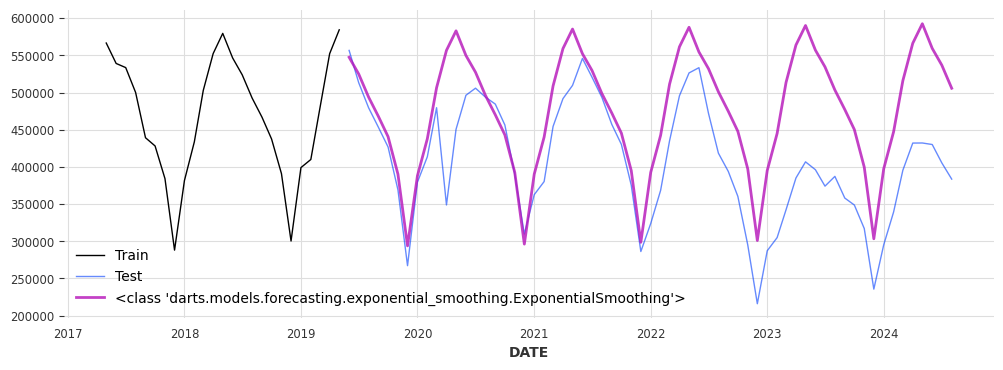

In [25]:
model = ExponentialSmoothing(seasonal_periods=12)
model.fit(train)
pred = model.predict(len(test))
train.plot(label='Train', linewidth=1)
test.plot(label='Test', linewidth=1, alpha=0.6)
pred.plot(label=f'{ExponentialSmoothing}', alpha=0.8)
plt.show()
# print(f"{model_name} MAPE: {mape(test, pred):.2f}%.)")

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\darts\timeseries.py:732: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


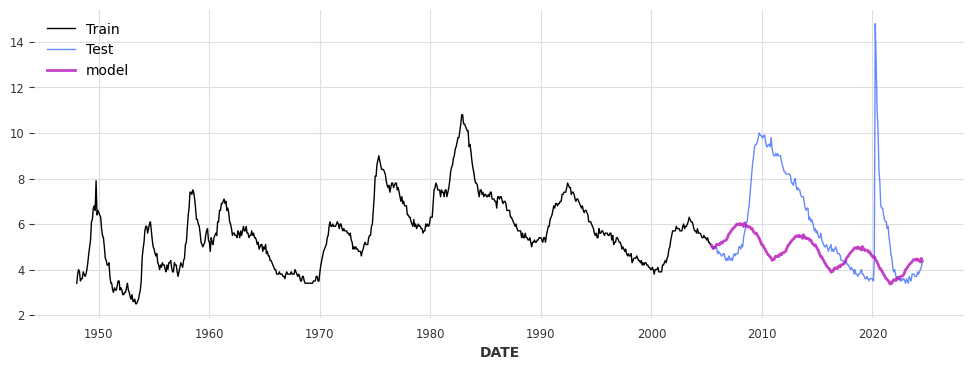

In [42]:
unemployment_rate = pd.read_csv('data/UNRATE.csv')
unemployment_rate.rename(columns={"UNRATE":'rate'}, inplace=True)
unemployment_rate['DATE'] = unemployment_rate['DATE'].astype('datetime64[us]')

series = TimeSeries.from_dataframe(unemployment_rate, time_col='DATE')
train, test = series.split_after(0.75)

model = ExponentialSmoothing(seasonal_periods=64)
model.fit(train)
pred = model.predict(len(test))
train.plot(label='Train', linewidth=1)
test.plot(label='Test', linewidth=1, alpha=0.6)
pred.plot(label=f'model', alpha=0.8)
plt.show()

In [28]:
i=0
for _, row in recessions.iterrows():
    if row['End'] > unemployment_rate['DATE'].min():
        i+=1
i

12

In [43]:
# Thoughts: probabilistic approach, historically when we have seen this rate of change, what occured next?